### Partea 1 (6p)

**Scop:** In aceasta prima parte a laboratorului dorim sa ne familiarizam cu modelele disponibile pe [HuggingFace](https://huggingface.co/) si sa le adaptam task-ului nostru.

**Task:** Zero-Shot Classsification folosind [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip).

In [1]:
# Intr-o celula separata adaugam importurile necesare
# Daca acestea nu functioneaza putem adauga o noua celula si "!pip install"

from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

In [2]:
# Incarcarea modelului
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
# Si a processor-ului
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

# Citirea imaginii de tip URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [4]:
# Descrierile textuale
texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

# Inferenta
with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)
print(f"{probs[0][0]:.1%} that image is '{texts[0]}'") # Probabilitatile extrase

31.9% that image is 'a photo of 2 cats'


#### Warm-up (0.5p)

Extrage si prabilitatea celei de-a doua descrieri vis-a-vis de poza de input. Cum comentezi rezultatul obtinut?

#### Compara cu CLIP (0.5p)


<img src="https://drive.google.com/uc?id=1nxy7wLRqVi_I1f9pNX8TViIpn88i9rR1">

Adapteaza codul de mai sus astfel incat sa vezi care sunt cele 4 tipuri de probabilitati pe care SigCLIP le scoate pentru cele 4  tipuri de clase din imaginea de mai sus.



#### Custom Dataset si functie de citire (2p)

**a)** Creaza o functie care iti permite sa citesti imagini salvate fie pe disk, fie URLs.


In [5]:
def read_image(input_image_path):
  # TODO
  print("Nu sunt implementata..inca!")

**b)** Alege 10 imagini diferite atat ca continut cat si ca sursa (local sau URL). Pentru fiecare dintre imagini alege 3 label-uri potentiale. Cum?

**Exemplu:** Sa spunem ca folosim o imagine cu o pisicuta. 2 dintre label-uri vor fi apropiate dpdv semantic subiectului `["an orange cat", "cutie purr cat"]`, iar ultimul va fi departat `["a bus"]`.

_Hint:_ Te poti folosi de o structura de date (exemplu dictionar) care sa iti permita sa retii maparea imagine ~ labels.

Salveaza aceasta mapare intr-o variabila, te va ajuta in exercitiul urmator!

#### Zero-Shot Classification simplificat (2p)

In scheletul de mai jos vedem cum putem incarca direct un pipeline de clasificare zero-shot. Tot ce ramane de facut este sa automatizam procesul de inferenta astfel incat el sa treaca prin fiecare imagine din dataset-ul costum si sa acorde scores pentru label-urile candidat.

In [6]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
image_classifier = pipeline(task="zero-shot-image-classification", model="google/siglip-base-patch16-224")

# load image: [Aceasta este zona in care read_image() de mai sus va fi folosita]
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# inference
# [Aceasta este zona in care vrem sa scoatem predictii pentru fiecare imagine si label-urile aferente]
outputs = image_classifier(image, candidate_labels=["2 cats", "a plane", "a remote"])
outputs = [{"score": round(output["score"], 4), "label": output["label"] } for output in outputs]
print(outputs)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


[{'score': 0.1979, 'label': '2 cats'}, {'score': 0.0, 'label': 'a remote'}, {'score': 0.0, 'label': 'a plane'}]


#### Validare (1p)

* Defineste human-confidence score-ul tau pentru label-ul pe care il consideri cel mai relavant din seria de 3 label-uri posibile ale unei imagini.

**Exemplu:**

<img src="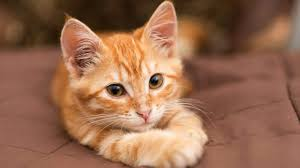
">

`["an orange cat", "cutie purr cat", "a bus"]`

Pentru poza de mai sus setam un scor de 0.9 pentru label-ul de referinta `"an orange cat"` (Acesta este GT score-ul setat de noi).

* Comparam matematic daca diferenta dintre scorul prezis de SigClip si GT score-ul nostru **NU** este mai mare de 20%.

* Insumam matematic si vedem pentru cate din cele 10 imagini aceasta diferenta este aplicabila.


Resurse:

[SigLIP huggingface documentation](https://huggingface.co/docs/transformers/en/model_doc/siglip)

[Huggingface dataset](https://huggingface.co/docs/datasets/en/loading)



## Partea a2a: Image Captioning (4p)

In [7]:
# Imports necesare pt data
import pandas as pd
from PIL import Image
import io
import ast

### Optiunea 1 de incarcare a datelor

`Pokemon Images and Text Descriptions` este Datasetul folosit pentru acest task si poate fi descarcat de pe [Kaggle](https://www.kaggle.com/datasets/thedevastator/pokemon-llava-images-and-text-descriptions). Ne intereseaza sa extragem `train.csv` file pe care apoi il putem incarca in Google Colab(Procesul de load al datelor va dura cateva minute).

_Obs:_ In suportul de laborator am folosit `train_small.csv`, o versiune care contine 70 de random samples extrase din `train.csv`.

Daca vrei sa descarci si incarci `train_small.csv` il gasesti [aici](https://drive.google.com/file/d/1oxCpIQvNZ6FnjhaTUayw7kz8MqU2pfA0/view?usp=sharing).

In [8]:
from google.colab import files
uploaded = files.upload()

Saving train_small.csv to train_small.csv


In [9]:
df = pd.read_csv(io.BytesIO(uploaded['train_small.csv']))

In [10]:
df.head(2)

image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                                text  
0              A deer with pink flowers on its back.  
1  A cartoon turtle with a gun on each hand and a...

### Optiunea 2 de incarcare a datelor

Daca aveti tokens de autentificare si acces pe huggingface, puteti folosi direct dataset-ul Pokemon. Cod util:

Install rapid cu:

```bash
!pip install -q datasets
```

```python
# Partea aceasta este necesara pentru autentificare
from huggingface_hub import notebook_login

notebook_login()

# Pokemonii si descrierile lor sunt salvati in variabila dataset
from datasets import load_dataset
dataset = load_dataset("lambdalabs/pokemon-blip-captions")
```

_Hint:_ [Resursa Suport pentru acest task si ghidare catre outputul dorit](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning)

In [ ]:
# !pip install datasets
# Am comentat linia de mai sus; Decomenteaz-o daca vrei sa mergi pe Optiunea 2
# Este doar un demo: Poti lua codul din markdown si pune intr-o celula Colab de Cod ;)

  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)


### Optiunea 3 de incarcare a datelor

Poti lucra tot acest laborator local daca resursele iti permit, si atunci doar vei citi de pe disk `train.csv` punand path-ul corect si folosindu-te de codul de la `Optiunea 1` pentru incarcare a datelor intr-un dataframe.

### Citirea si Vizualizarea datelor

In [11]:
# Observam ca in df avem 2 coloane care mentin perechile imagine ~ text
df.columns

Index(['image', 'text'], dtype='object')

In [12]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

# Acest helper function ne ajuta sa vizualizam imaginile si caption-urile aferenete

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

In [13]:
# Acest helper function ne permite sa decodificam imaginile din df
def convert_bytes_to_Image(byte_array) :
    return Image.open(io.BytesIO((ast.literal_eval(byte_array)['bytes'])))

In [14]:
# Iar aici aplicam functia de mai sus
sample_images_to_visualize = [np.array(convert_bytes_to_Image(df["image"][i])) for i in range(5)]

In [15]:
df['text'][0]

'A deer with pink flowers on its back.'

In [16]:
sample_captions = [df["text"][i] for i in range(5)]

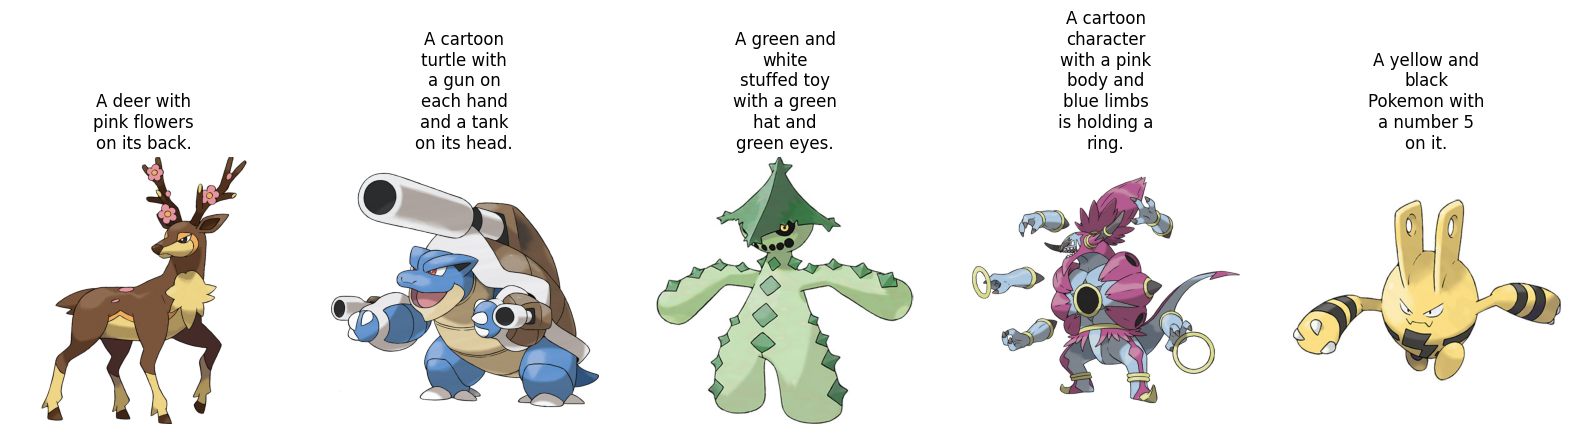

In [17]:
plot_images(sample_images_to_visualize, sample_captions)

In [18]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [19]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [20]:
test_inference_image = convert_bytes_to_Image(df["image"][0])

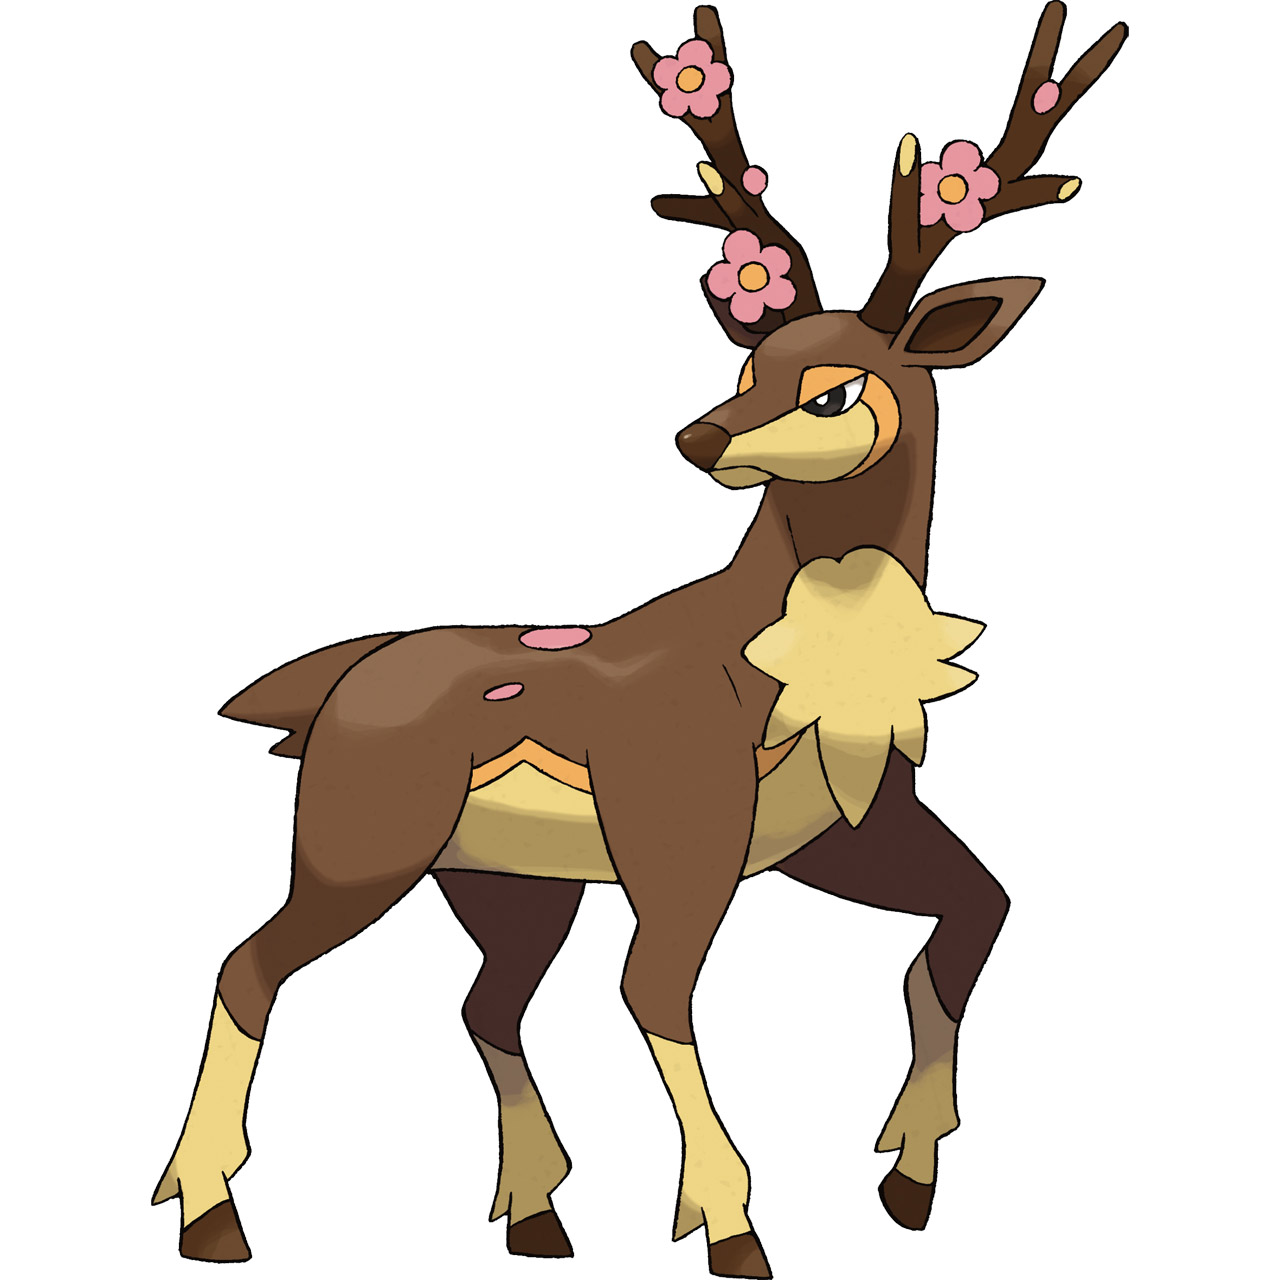

In [21]:
test_inference_image

In [22]:
import torch

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=test_inference_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the last token (EOS token) of the input_ids and attention_mask tensors will be removed. To test the new behavior, set `legacy=False`as a processor call argument.


In [24]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

illustration of a deer with pink flowers on its ears


In [25]:
print('Ground-truth caption: ', sample_captions[0])
print('Descrierea generata:', generated_caption)

Ground-truth caption:  A deer with pink flowers on its back.
Descrierea generata: illustration of a deer with pink flowers on its ears


### Testeaza modelul (2p)

Similar exemplului de mai sus, alege 20 de perechi de Pokemoni si descrierile lor si verifica daca modelul ales ofera captions care match-uiesc descrierile din GT. Ce observi? Daca ar fi sa faci o Validare numerica similara exemplului din `Partea 1`, cate din imagini si descrierile lor ar face un match folosind human supervision-ul tau?

### Fine-tuneaza modelul (2p)

Foloseste-te de [Resursa Suport pentru acest task si ghidare catre outputul dorit](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning) si adapteaza procesul de fine-tunare pe datele tale.

_Obs:_ Daca ai ales Optiunea 1 sau 3 de incarcare a datelor, poti folosi `train.csv` ca input data si pe el sa il imparti in train ~ test (Aici depinde de cum ai facut load-ul datelor tale).

**Foarte important:** Grija la data leakage❗❗❗ Pentru a testa modelul dupa fine-tune trebuie sa folosim date cu pokemoni dintr-o distributie pe care modelul NU a vazut-o la antrenare.